In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from itertools import cycle
from transformers import AutoTokenizer
from sentencepiece import SentencePieceProcessor
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

2.1.0+cu121
cuda:0 (8, 6)


### Llama 2 from Scratch

In [2]:
# Using Huggingface
tokenizer = AutoTokenizer.from_pretrained("./llama2/")
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
# tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [3]:
def encode(example):
    return tokenizer.encode(example, return_tensors="pt")


def decode(example):
    return tokenizer.batch_decode(
        example,
        skip_special_tokens=False,
        clean_up_tokenization_spaces=True,
    )[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 32001


'<s> hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "hidden_dim": 768,
    "epochs": 1000,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}
GLOBAL_KEEP_TRACK = []

In [5]:
# Local Data only
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/TinyStoriesv1andv2-train.txt"],
        "val": ["../../data/TinyStoriesv1andv2-valid.txt"],
    },
    streaming=True,
)

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example["text"]) > 2)

In [6]:
prompt = "Write a short story. Possible Story: "
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        [prompt + x for x in examples["text"]],
        padding=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

test = next(train_data)
print(f"Actual text: {test['text']}")
print(f"Input Ids: {tokenizer.decode(test['input_ids'])}")
print(f"Length of text: {len(test['input_ids'])}")
print(test)

Actual text: Bob said, "You're welcome! I'm glad you're happy." 
Input Ids: <s> Write a short story. Possible Story: Bob said, "You're welcome! I'm glad you're happy." <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
Length of text: 169
{'text': 'Bob said, "You\'re welcome! I\'m glad you\'re happy." ', 'input_ids': tensor([    1, 14350,   26

### Needed functions

In [7]:
# @torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(
        batch_size
    ):  # Adjust this lower if you're running out of memory
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data["input_ids"]) - context_window - 1, (2,)
        )
        batch_x = torch.stack(
            [batch_data["input_ids"][i : i + context_window] for i in ix]
        ).long()
        batch_y = torch.stack(
            [
                batch_data["input_ids"][i + 1 : i + context_window + 1]
                for i in ix
            ]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y


def get_lora_batches(
    data,
    batch_size,
    context_window=32,
):
    x = []
    y = []
    for _ in range(batch_size // 2):
        x_data = next(data)
        y_data = next(data)

        x_data = torch.stack([x_data["input_ids"]]).long()
        y_data = torch.stack([y_data["input_ids"]]).long()

        x.append(x_data)
        y.append(y_data)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    return x, y

In [8]:
@torch.no_grad()
def get_loss(model, lora=False, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(["train", "val"], [train_data, val_data]):
        losses = []
        for _ in range(10):
            if lora == True:
                xb, yb = get_lora_batches(
                    split, config["batch_size"], config["context_window"]
                )
            else:
                xb, yb = get_batches(
                    split,
                    config["batch_size"],
                    config["context_window"],
                )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
    lora=False,
):
    idx_list = [tokenized_prompt] * 5
    idx = torch.cat((idx_list), 0).long().to(device)
    if lora:
        idx = (
            torch.ones(5, 1).long().to(device)
        )  # Alternative without prompt
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[last_time_step_logits < v[:, [-1]]] = (
                -float("Inf")
            )
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Gross neural network that doesn't work

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
# opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

model params: 18547809


### Training Loop

In [10]:
def train(
    model,
    optimizer,
    scheduler=None,
    data=None,
    config=MASTER_CONFIG,
    lora=False,
    print_logs=False,
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            if lora:
                xs, ys = get_lora_batches(data, config["batch_size"])
            else:
                xs, ys = get_batches(
                    data, config["batch_size"], config["context_window"]
                )

            for i in range(1, config["context_window"] + 1):
                x = xs[:i]
                y = ys[:i]
                logits, loss = model(x, targets=y)
                loss.backward()
                optimizer.step()

                if scheduler:
                    scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model, lora=lora)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(
        f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']:.3f} | Val: {losses[-1]['val']:.3f}"
    )
    print(
        f"training loss {losses[-1]['train']:.3f} | validation loss: {losses[-1]['val']:.3f}"
    )
    return pd.DataFrame(losses).plot(xlabel="Step // 50", ylabel="Loss")

Epoch 0 | train loss 9.845 | val loss 9.761 | Time 0.170 | ETA: 0:00:03.397660
Epoch 50 | train loss 10.823 | val loss 9.866 | Time 7.867 | ETA: 0:02:29.471530
Epoch 100 | train loss 9.601 | val loss 9.966 | Time 7.879 | ETA: 0:02:21.824617
Epoch 150 | train loss 8.915 | val loss 9.315 | Time 7.955 | ETA: 0:02:15.234974
Epoch 200 | train loss 9.195 | val loss 8.380 | Time 7.956 | ETA: 0:02:07.296486
Epoch 250 | train loss 8.075 | val loss 7.651 | Time 7.994 | ETA: 0:01:59.909999
Epoch 300 | train loss 8.438 | val loss 8.266 | Time 7.962 | ETA: 0:01:51.467995
Epoch 350 | train loss 7.329 | val loss 7.619 | Time 7.893 | ETA: 0:01:42.609324
Epoch 400 | train loss 7.537 | val loss 7.025 | Time 7.937 | ETA: 0:01:35.241225
Epoch 450 | train loss 6.622 | val loss 6.708 | Time 7.981 | ETA: 0:01:27.791015
Epoch 500 | train loss 7.247 | val loss 7.561 | Time 7.916 | ETA: 0:01:19.159999
Epoch 550 | train loss 7.095 | val loss 6.863 | Time 7.936 | ETA: 0:01:11.425222
Epoch 600 | train loss 7.017 |

<Axes: xlabel='Step // 50', ylabel='Loss'>

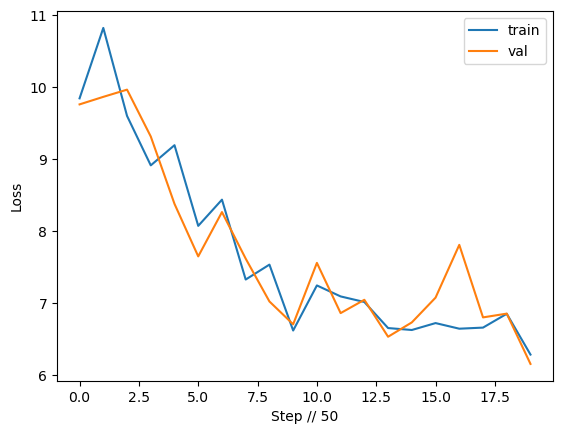

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story: ..............................',
 '<s> Write a short story. Possible Story: ..............................',
 '<s> Write a short story. Possible Story: ..............................',
 '<s> Write a short story. Possible Story: ..............................',
 '<s> Write a short story. Possible Story: ..............................']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 6.288 | Val: 6.158


### RMS Normalization

This is as opposed to the original Batch Normalization used in the original transformers paper.
Basically it works by taking 1/sqrt(N) * frobenius_norm

In [14]:
class RMSNormalization(nn.Module):
    def __init__(self, layer_shape, eps=1e-5, bias=False):
        super(RMSNormalization, self).__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(layer_shape))
        )

    def forward(self, x):
        """
        assumes shape (batch, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1, 2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[: x.shape[1], :].unsqueeze(0) * raw

model params: 18630753
Epoch 0 | train loss 10.923 | val loss 10.607 | Time 0.091 | ETA: 0:00:01.819968
Epoch 50 | train loss 8.745 | val loss 7.814 | Time 8.359 | ETA: 0:02:38.826829
Epoch 100 | train loss 7.393 | val loss 7.215 | Time 8.227 | ETA: 0:02:28.090279
Epoch 150 | train loss 7.416 | val loss 6.650 | Time 8.227 | ETA: 0:02:19.864496
Epoch 200 | train loss 6.942 | val loss 6.516 | Time 8.225 | ETA: 0:02:11.597015
Epoch 250 | train loss 6.431 | val loss 6.197 | Time 8.333 | ETA: 0:02:04.991537
Epoch 300 | train loss 5.906 | val loss 6.065 | Time 8.300 | ETA: 0:01:56.202069
Epoch 350 | train loss 5.796 | val loss 5.797 | Time 8.293 | ETA: 0:01:47.808377
Epoch 400 | train loss 5.867 | val loss 5.912 | Time 8.251 | ETA: 0:01:39.009330
Epoch 450 | train loss 5.745 | val loss 5.174 | Time 8.229 | ETA: 0:01:30.520829
Epoch 500 | train loss 6.134 | val loss 5.922 | Time 8.311 | ETA: 0:01:23.110254
Epoch 550 | train loss 6.050 | val loss 5.905 | Time 8.256 | ETA: 0:01:14.304595
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

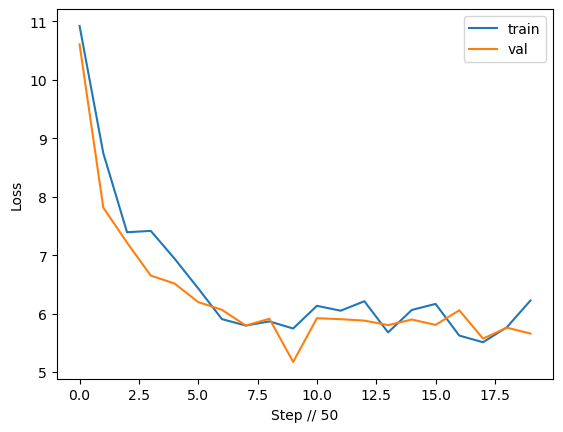

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<s> Write a short story. Possible Story:  and.............................',
 '<s> Write a short story. Possible Story:  and.............................',
 '<s> Write a short story. Possible Story:  and.............................',
 '<s> Write a short story. Possible Story:  and.............................',
 '<s> Write a short story. Possible Story:  and.............................']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 18547809 Params | Train: 6.288 | Val: 6.158
SimpleFeedForwardNN_RMS 18630753 Params | Train: 6.225 | Val: 5.659


### RoPE scaling

Rotary Embeddings changes the positional encoding from being based on sine and cosine to being based on the rotation of the embeddings, with a different rotation at each position

In [18]:
@jit(
    nopython=False
)  # Careful running @jit and @njit in a jupyter notebook, nopython compilation might fail.
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

C:\Users\chris\AppData\Local\Temp\ipykernel_16300\388148385.py:1: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(


C:\Users\chris\AppData\Local\Temp\ipykernel_16300\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Unknown attribute 'zeros' of type Module(<module 'torch' from 'c:\\Users\\chris\\anaconda3\\envs\\llmbook\\Lib\\site-packages\\torch\\__init__.py'>)

File "..\..\..\..\AppData\Local\Temp\ipykernel_16300\388148385.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\chris\AppData\Local\Temp\ipykernel_16300\388148385.py (5)

File "..\..\..\..\AppData\Local\Temp\ipykernel_16300\388148385.py", line 5:
<source missing, REPL/exec in use?>

  @jit(
C:\Users\chris\AppData\Local\Temp\ipykernel_16300\388148385.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_rotary_matrix" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

Fil

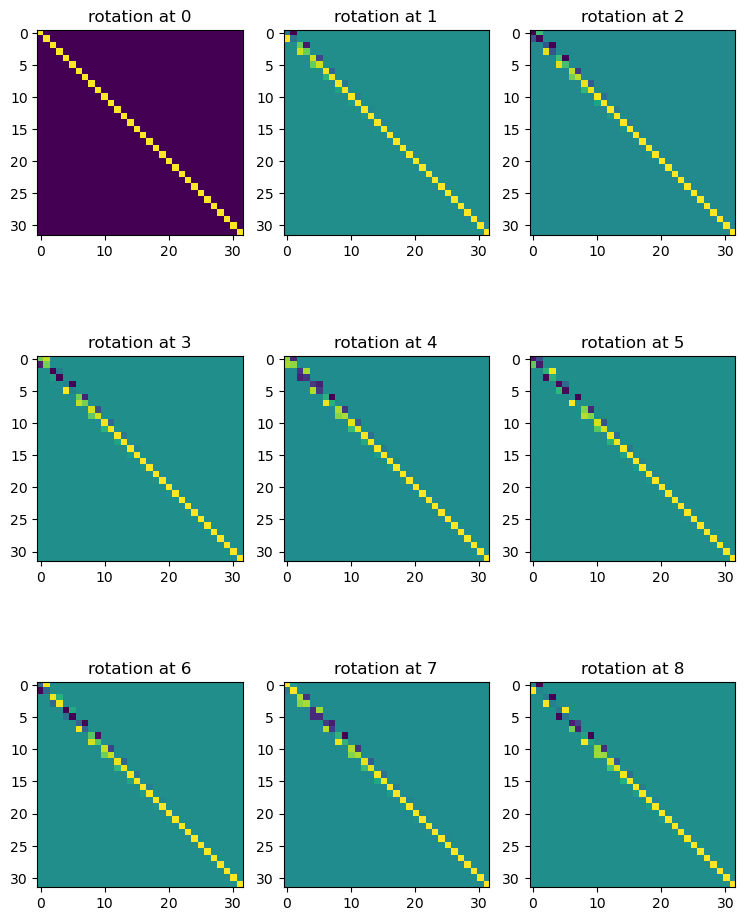

In [19]:
from IPython.display import clear_output

K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
# clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (
            (torch.bmm(q.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )
        k_rotated = (
            (torch.bmm(k.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(
                device
            )
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chris\AppData\Local\Temp\ipykernel_16300\2521293711.py:27: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(nopython=False)


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(
            device
        )

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

model params: 20621697
Epoch 0 | train loss 12.289 | val loss 12.527 | Time 0.473 | ETA: 0:00:09.451323
Epoch 50 | train loss 7.030 | val loss 7.077 | Time 14.856 | ETA: 0:04:42.269095
Epoch 100 | train loss 6.580 | val loss 6.675 | Time 14.754 | ETA: 0:04:25.569240
Epoch 150 | train loss 6.074 | val loss 6.494 | Time 14.733 | ETA: 0:04:10.453786


KeyboardInterrupt: 

In [ ]:
generate(model, config=MASTER_CONFIG)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

### SwiGLU

Replace ReLU activation function. Defined as SwiGLU(x) = Swishβ(xW + b)⊗︀(xV + c)

In [ ]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

In [ ]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [ ]:
generate(model, config=MASTER_CONFIG)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

In [ ]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc

gc.collect()

### Llama

So what makes Llama 2 different from regular simple feed forward networks? Blocks of RMSNorm and Residual Rope Attention. Let's make those blocks and create our model

In [ ]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["hidden_dim"]),
            SwiGLU(config["hidden_dim"]),
            nn.Linear(config["hidden_dim"], config["d_model"]),
        ).to(device)

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [ ]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

In [ ]:
MASTER_CONFIG["epochs"] = 1000

llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(
    llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True
)

This is why you need a scheduler lol

In [ ]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=25,
    max_new_tokens=50,
)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

In [ ]:
# MASTER_CONFIG["epochs"] = 5000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 768
MASTER_CONFIG["n_layers"] = 8
# MASTER_CONFIG["context_window"] = 128

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=1e-1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

In [ ]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [ ]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=100,
    max_new_tokens=50,
)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

In [ ]:
# LLAMA_CONFIG = {
#     "vocab_size": 32000,
#     "batch_size": 2,
#     "context_window": 256,
#     "d_model": 768,
#     "hidden_dim": 1536,
#     "epochs": 1,
#     "log_interval": 1,
#     "n_heads": 8,
#     "n_layers": 8,
# }

# # Llama2 7b config:
# # LLAMA_2_7b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 4096,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 11008,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 32,
# #     "n_layers": 32,
# #     "num_key_value_heads": 32,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# # }

# # # Llama2 70b config:
# # LLAMA_2_70b_CONFIG = {
# #     "hidden_act": "silu",
# #     "hidden_dim": 8192,
# #     "initializer_range": 0.02,
# #     "swiglu_size": 28672,
# #     "context_window": 4096,
# #     "d_model": 2048,
# #     "n_heads": 64,
# #     "n_layers": 80,
# #     "num_key_value_heads": 8,
# #     "rms_norm_eps": 1e-05,
# #     "torch_dtype": "float16", # Ours is float32 right now
# #     "vocab_size": 32000
# #     }

In [ ]:
# Training with epochs instead of steps
# def train(
#     model, optimizer, dataset, scheduler=None, config=LLAMA_CONFIG, print_logs=False
# ):
#     losses = []

#     start_time = time.time()
#     for epoch in range(config["epochs"]):
#         for step, example in enumerate(dataset):
#             try:
#             optimizer.zero_grad()

#             xs, ys = _get_batch(example, 2, config['context_window'])
#             _, loss = model(xs, targets=ys)
#             loss.backward()
#             optimizer.step()

#             if scheduler:
#                 scheduler.step()

#             if i % config["log_interval"] == 0:
#                 batch_time = time.time() - start_time
#                 x = get_loss(model)
#                 losses += [x]
#                 if print_logs:
#                     print(
#                         f"Epoch {epoch} | Step {i} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds: {batch_time * (config['epochs'] - i) :.3f}"
#                     )
#                 start_time = time.time()

#                 if scheduler:
#                     print("lr: ", scheduler.get_last_lr())
#               except StopIteration:
#                   print(f"Finished dataset at step {step}")
#                   break
#     print(f"training loss {losses[-1]['train']} | validation loss: {losses[-1]['val']}")
#     GLOBAL_KEEP_TRACK.append(f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']} | Val: {losses[-1]['val']}")
#     return pd.DataFrame(losses).plot()

In [ ]:
# llama = Llama(LLAMA_CONFIG).to(device)

# llama_optimizer = torch.optim.Adam(
#     llama.parameters(),
#     betas=(0.9, 0.95),
#     weight_decay=0.1,
#     eps=1e-9,
#     lr=1e-3,
# )
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     llama_optimizer, 1000, eta_min=1e-5
# )

# Quantization

In [ ]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig,
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)


# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size


def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size


def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size


def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(
            f"{type(model).__name__} size: {size_all_mb:.3f}MB"
        )
    return keeping_track


list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [ ]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(
            torch.randn(in_dim, rank) * standard_deviation
        )
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [ ]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(
        self,
        fan_in,
        fan_out,
        fan_in_fan_out=False,
        rank=0,
        lora_dropout_p=0.0,
        lora_alpha=1,
    ):
        super().__init__()
        self.swap = (
            (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        )
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = (
            nn.Dropout(p=lora_dropout_p)
            if lora_dropout_p > 0
            else lambda x: x
        )
        self.dropout_fn = (
            self._dropout if lora_dropout_p > 0 else lambda x: x
        )
        self.register_buffer(
            "lora_dropout_mask",
            torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype),
        )
        self.forward_fn = self.lora_forward

    def forward(self, X):
        return self.forward_fn(X)

    def lora_forward(self, X):
        return (
            X
            + torch.matmul(
                *self.swap((self.lora_B, self.dropout_fn(self.lora_A)))
            ).view(X.shape)
            * self.scaling
        )

    @classmethod
    def lora_from_layer(
        cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1
    ):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in,
            fan_out,
            fan_in_fan_out=False,
            rank=rank,
            lora_dropout_p=lora_dropout_p,
            lora_alpha=lora_alpha,
        )


lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}


def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[
                type(layer)
            ].items():
                torch.nn.utils.parametrize.register_parametrization(
                    layer, attr_name, parametrization(layer)
                )
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(
                    layer, attr_name, leave_parametrized=merge
                )


def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))


def remove_lora(model):
    """remove lora parametrization to all layers in a model. This will remove all parametrization"""
    model.apply(partial(apply_lora, register=False, merge=False))


def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))


def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p


def get_lora_params(model, print_shapes=False):
    return get_params_by_name(
        model, print_shapes=print_shapes, name_filter=name_is_lora
    )

In [ ]:
# # Show how the blocks change, but we'll use our already-trained model
# class LlamaBlock(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         self.rms = RMSNormalization(
#             (config["d_model"], config["d_model"])
#         ).to(device)

#         self.attention = RoPEMaskedMultiheadAttention(config).to(device)
#         self.feedforward = nn.Sequential(
#             LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
#             SwiGLU(config["d_model"]),
#         ).to(device)

#     def forward(self, x):
#         x = self.rms(x)
#         x = x + self.attention(x)

#         x = self.rms(x)
#         x = x + self.feedforward(x)
#         return x


# class SimpleLlama(nn.Module):
#     def __init__(self, config):
#         super().__init__()
#         self.config = config

#         self.embedding = nn.Embedding(
#             config["vocab_size"], config["d_model"]
#         )
#         self.llama_blocks = nn.Sequential(
#             OrderedDict(
#                 [
#                     (f"llama_{i}", LlamaBlock(config))
#                     for i in range(config["n_layers"])
#                 ]
#             )
#         )

#         self.ffn = nn.Sequential(
#             LinearWithLoRA(config["d_model"], config["d_model"]),  # NEW
#             SwiGLU(config["d_model"]),
#             LinearWithLoRA(config["d_model"], config["vocab_size"]),  # NEW
#         )

#         print(
#             f"model params: {sum([m.numel() for m in self.parameters()])}"
#         )

#     def forward(self, idx, targets=None):
#         x = self.embedding(idx)
#         x = self.llama_blocks(x)
#         logits = self.ffn(x)

#         if targets is None:
#             return logits

#         else:
#             loss = F.cross_entropy(
#                 logits.view(-1, self.config["vocab_size"]),
#                 targets.view(-1),
#                 ignore_index=tokenizer.pad_token_id,
#                 # reduction="sum",
#             )
#             return logits, loss

In [ ]:
# New Dataset for Lora
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/Lima-train.csv"],
        "val": ["../../data/Lima-test.csv"],
    },
    streaming=True,
)

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        padding=True,
        max_length=MASTER_CONFIG["context_window"],
        truncation=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

In [ ]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [{"params": list(get_lora_params(llama))}]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)

In [ ]:
# Step 4: Train
train(
    llama,
    lora_optimizer,
    scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    lora=True,
    print_logs=True,
)

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k: v for k, v in state_dict.items() if name_is_lora(k)}

In [ ]:
torch.save(llama.state_dict(), "./llama2/llama.pth")
torch.save(lora_state_dict, "./llama2/lora.pth")

In [ ]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama, lora=True)

# remove_lora(llama)

In [ ]:
from train_utils import FSDP_QLORA

trainer = FSDP_QLORA(
    model_name="meta-llama/Llama-2-13b-hf",
    batch_size=2,
    context_length=2048,
    precision="bf16",
    train_type="qlora",
    use_gradient_checkpointing=True,
    dataset="alpaca",
    reentrant_checkpointing=True,
)

trainer.train_qlora()

In [ ]:
from safetensors import safe_open
import torch
from transformers import LlamaForCausalLM, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

tensors = {}
with safe_open(
    "qlora_output/model_state_dict.safetensors", framework="pt", device=0
) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

for k in tensors:
    if "lora" not in k:
        tensors[k] = None

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    use_cache=False,
    quantization_config=bnb_config,
)

for param in model.parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=[
        "k_proj",
        "q_proj",
        "v_proj",
        "up_proj",
        "down_proj",
        "gate_proj",
    ],
)
model = get_peft_model(model, peft_config)

list(model.state_dict().keys())[:10]

new_sd = model.state_dict()
for k in new_sd:
    if "lora" in k:
        new_sd[k] = tensors[k]

model.load_state_dict(new_sd)

model.save_pretrained("lora_adapters")

In [ ]:
# Create a Gradio app that looks like this:

# # Space will need your token to request hardware: set it as a Secret !
# HF_TOKEN = os.environ.get("HF_TOKEN")

# # Space own repo_id
# TRAINING_SPACE_ID = "your_username/your_repo"

# from huggingface_hub import HfApi, SpaceHardware
# api = HfApi(token=HF_TOKEN)

# # On Space startup, check if a task is scheduled. If yes, finetune the model. If not,
# # display an interface to request a new task.
# task = get_task()
# if task is None:
#     # Start Gradio app
#     def gradio_fn(task):
#         # On user request, add task and request hardware
#         add_task(task)
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

#     gr.Interface(fn=gradio_fn, ...).launch()
# else:
#     runtime = api.get_space_runtime(repo_id=TRAINING_SPACE_ID)
#     # Check if Space is loaded with a GPU.
#     if runtime.hardware == SpaceHardware.CPU_BASIC:
#         # If yes, finetune base model on dataset !
#         chat_with_user(task)

#         # Then, mark the task as "DONE"
#         mark_as_done(task)

#         # DO NOT FORGET: set back CPU hardware
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)
#     else:
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

In [ ]:
%pip install huggingface_hub -q

from huggingface_hub import notebook_login, HfApi

notebook_login()

In [ ]:
api = HfApi()
api.create_repo(
    repo_id="your_username/your_repo", repo_type="space", space_sdk="gradio"
)

In [ ]:
stuff_to_save = [
    "llama.pth",
    "lora.pth",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "tokenizer.model",
    "gradio_app.py",
]
for thing in stuff_to_save:
    api.upload_file(
        path_or_fileobj=f"./llama2/{thing}",
        path_in_repo=thing,
        repo_id="your_username/your_repo",
        repo_type="space",
    )